In [1]:
import json
import os
from collections import defaultdict
import numpy as np
from torch.utils.data import Dataset
import torch



class FEMNIST(Dataset):
    """
    This dataset is derived from the Leaf repository
    (https://github.com/TalwalkarLab/leaf) pre-processing of the Extended MNIST
    dataset, grouping examples by writer. Details about Leaf were published in
    "LEAF: A Benchmark for Federated Settings" https://arxiv.org/abs/1812.01097.
    """

    def __init__(self, train=True, transform=None, target_transform=None, ):
        super(FEMNIST, self).__init__()
        self.transform = transform
        self.target_transform = target_transform
        self.train = train

        train_clients, train_groups, train_data_temp, test_data_temp = read_data("./data/femnist/train",
                                                                                 "./data/femnist/test")
        if self.train:
            self.dic_users = {}
            train_data_x = []
            train_data_y = []
            for i in range(len(train_clients)):
                if i == 100:
                    break
                self.dic_users[i] = set()
                l = len(train_data_x)
                cur_x = train_data_temp[train_clients[i]]['x']
                cur_y = train_data_temp[train_clients[i]]['y']
                for j in range(len(cur_x)):
                    self.dic_users[i].add(j + l)
                    train_data_x.append(np.array(cur_x[j]).reshape(28, 28))
                    train_data_y.append(cur_y[j])
            self.data = train_data_x
            self.label = train_data_y
        else:
            test_data_x = []
            test_data_y = []
            for i in range(len(train_clients)):
                cur_x = test_data_temp[train_clients[i]]['x']
                cur_y = test_data_temp[train_clients[i]]['y']
                for j in range(len(cur_x)):
                    test_data_x.append(np.array(cur_x[j]).reshape(28, 28))
                    test_data_y.append(cur_y[j])
            self.data = test_data_x
            self.label = test_data_y

    def __getitem__(self, index):
        img, target = self.data[index], self.label[index]
        img = np.array([img])
        # img = Image.fromarray(img, mode='L')
        # if self.transform is not None:
        #     img = self.transform(img)
        # if self.target_transform is not None:
        #     target = self.target_transform(target)
        return torch.from_numpy((0.5-img)/0.5).float(), target

    def __len__(self):
        return len(self.data)

    def get_client_dic(self):
        if self.train:
            return self.dic_users
        else:
            exit("The test dataset do not have dic_users!")
def batch_data(data, batch_size, seed):
    '''
    data is a dict := {'x': [numpy array], 'y': [numpy array]} (on one client)
    returns x, y, which are both numpy array of length: batch_size
    '''
    data_x = data['x']
    data_y = data['y']

    # randomly shuffle data
    np.random.seed(seed)
    rng_state = np.random.get_state()
    np.random.shuffle(data_x)
    np.random.set_state(rng_state)
    np.random.shuffle(data_y)

    # loop through mini-batches
    for i in range(0, len(data_x), batch_size):
        batched_x = data_x[i:i + batch_size]
        batched_y = data_y[i:i + batch_size]
        yield (batched_x, batched_y)


def read_dir(data_dir):
    clients = []
    groups = []
    data = defaultdict(lambda: None)

    files = os.listdir(data_dir)
    files = [f for f in files if f.endswith('.json')]
    for f in files:
        file_path = os.path.join(data_dir, f)
        with open(file_path, 'r') as inf:
            cdata = json.load(inf)
        clients.extend(cdata['users'])
        if 'hierarchies' in cdata:
            groups.extend(cdata['hierarchies'])
        data.update(cdata['user_data'])

    clients = list(sorted(data.keys()))
    return clients, groups, data



def read_data(train_data_dir, test_data_dir):
    '''parses data in given train and test data directories

    assumes:
    - the data in the input directories are .json files with
        keys 'users' and 'user_data'
    - the set of train set users is the same as the set of test set users

    Return:
        clients: list of client ids
        groups: list of group ids; empty list if none found
        train_data: dictionary of train data
        test_data: dictionary of test data
    '''
    train_clients, train_groups, train_data = read_dir(train_data_dir)
    test_clients, test_groups, test_data = read_dir(test_data_dir)

    assert train_clients == test_clients
    assert train_groups == test_groups

    return train_clients, train_groups, train_data, test_data



In [2]:
import matplotlib
import argparse
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch
import torch.nn as nn # import modules

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models_v1.Update import LocalUpdate
from models_v1.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, MobileNetV2, LeNet5, LeNet10
from models_v1.Fed import FedAvg
from models_v1.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models_v1.test import test_img

%load_ext autoreload
%autoreload 2
from torch.autograd import grad
parser = argparse.ArgumentParser(description='Deep Leakage from Gradients.')
parser.add_argument('--index', type=int, default="25",
                    help='the index for leaking images on CIFAR.')
parser.add_argument('--image', type=str,default="",
                    help='the path to customized image.')
args = parser.parse_args([])
from torch.autograd import grad

In [3]:
class my_argument:    
    epochs = 400    #"rounds of training"
    num_users = 100  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=1 #"the number of local epochs: E"
    local_bs=10 #"local batch size: B"
    bs=128 #"test batch size"
    lr=0.001 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'ADAM'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='femnist' #, help="name of dataset")
    iid=0
    num_classes=62#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    model='mlp'
    q=20
    f_size=32
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cpu")
args.device = torch.device("cuda:1" if use_cuda else "cpu")
print(args.device)

True
cuda:1


In [4]:
from models_v1.Fed import FedAdd,FedSubstract,weight_vectorization_gen,FedAvg_gradient, weight_vectorization_gen2


In [5]:
def phiQ(p,sc, q, w):
    w_cap = w #[:,0]
    #w_cap=[item[0] if isinstance(item,list) and len(item)>0 else item for item in w_cap]
    #w_cap=np.array(w_cap)
    #print("w_cap_first")
    #print(w_cap)
    w_cap= sc*w_cap
    v=np.floor(q*w_cap)
    one=np.ones(len(w))
    r=np.random.uniform(0,1,len(w_cap))
    temp=(one.T+np.sign(q*w_cap-v-r))*np.sign(q*w_cap-v-r)
    #j=np.sign(w_cap-v-r)
    #print("jjj")
    #print(j)
    #temp= (1/q)*(1/2)*temp
    temp=(1/2)*temp
    #print("temp")
    #print(temp)
    #w_cap= (1/q)*v + temp
    w_cap=(1/q)*(v+temp)
    w_cap=q*w_cap
    #w_cap=w_cap+ (1/2)*p*(-np.sign(w_cap)+one.T)*(-np.sign(w_cap))
    w_cap=w_cap+ (1/2)*(p-5)*(-np.sign(w_cap)+one.T)*(-np.sign(w_cap))
    #print("w_cap_last")
    #print(w_cap)
    del temp
    del one
    del v
    del r
    return w_cap

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('/data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('/data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
        print('iid dataset')
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
        print("non iid dataset")
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
elif args.dataset == 'femnist':
    dataset_train = FEMNIST(train=True)
    dataset_test = FEMNIST(train=False)
    dict_users = dataset_train.get_client_dic()
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape


In [ ]:
print(dataset_train[0][0])

In [6]:
def toNumpyFlatArray(self):
        return self.flat


def updateFromNumpyFlatArray(self, arr):
    self.flat = arr
    start = 0
    new_glob = OrderedDict()
    for k in self.w_glob.keys():
        size = 1
        for dim in self.w_glob[k].shape:
            size *= dim
        shaped = np.reshape(arr[start : start + size].copy(), self.w_glob[k].shape)
        new_glob[k] = torch.from_numpy(shaped)
        start = start + size
    self.w_glob = new_glob
    self.net_glob.load_state_dict(self.w_glob)

In [7]:
beta=[1,1/2,1/4,1/8,1/16]
beta=[1,1,1/2,1/2,1/4]
#beta=[1,1,1,1,1]
beta=[1,1/2,1/4]
comp=[]
i=0
for j in range(args.num_users):
    comp.append(beta[i])
    if (j>0 and j%33==0):
        i+=1


In [8]:
print(comp)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


In [9]:
#print(dict_users[2])

In [ ]:
#print(dict_users[10])

In [ ]:
print(len(dict_users[2]))

# 1. FedAvg with A=0

In [10]:

local_lr = 1e-4
local_steps = 1
use_updates = True

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        nn.init.xavier_uniform(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, torch.nn.Linear):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform_(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.BatchNorm2d):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform_(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
        #conv1.bias.data.fill_(0.01)

In [12]:
from models_v1.Fed import FedAdd,FedSubstract,weight_vectorization_gen,FedAvg_gradient
import numpy as np
import copy
import random
# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == "mobilenetv2":
    net_glob = MobileNetV2(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    print(len_in)
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.apply(weights_init)
net_glob.train()

784
MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=200, out_features=62, bias=True)
)


MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=200, out_features=62, bias=True)
)

In [13]:
print(len_in)
print(img_size)
print(args.num_classes)

784
torch.Size([1, 28, 28])
62


In [14]:
def update_local_model( w_hold,w_local, sub):
    count=0
    for i in sub:
            w_glob_hold['layer_input.weight'][int(50*i):int(50*(i+1)),:]=w_local['layer_input.weight'][count*50:(count+1)*50,:]
            
            #combined=torch.concatenate((first,middle),axis=0)
    
            w_glob_hold['layer_input.bias'][int(50*i):int(50*(i+1))]=w_local['layer_input.bias'][count*50:(count+1)*50]
            
    
    
            w_glob_hold['layer_hidden.weight'][:,int(50*i):int(50*(i+1))]=w_local['layer_hidden.weight'][:,count*50:(count+1)*50]
            
    
            w_glob_hold['layer_hidden.bias']=w_local['layer_hidden.bias']
            count+=1
            #combined=middle
    #w_glob['layer_hidden.weight']=combined
    return w_glob_hold

In [ ]:
print(s_1)

In [15]:
from models_v1.Fed import FedAdd,FedSubstract,weight_vectorization_cifar,FedAvg_gradient, weight_vectorization_gen, weight_vectorization_gen2
#net_glob = LeNet10().to(args.device)
#net_glob.train()
args.lr=0.00025
import torchvision.models as models
dev=torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
net_glob.apply(weights_init)
net_glob.train()
#net_glob.load_state_dict(w_glob)
net_glob=net_glob.to(dev)
w_glob=torch.load("linear_FEMNIST.pt")
net_glob.load_state_dict(w_glob)
net_glob.train()
# copy weights
#net_glob=torch.hub.load('pytorch/vision:v0.10.0','resnet18',pretrained=False)
#net_glob.eval()
w_glob = net_glob.state_dict()
g, dim = weight_vectorization_gen(w_glob)

w_glob=net_glob.state_dict()
# print(w_glob)
# print(w_glob.keys())
for k in w_glob.keys():
    print(w_glob[k].shape)
net_glob_original=copy.deepcopy(net_glob)
net_glob_original.to(dev)
w_glob_original=copy.deepcopy(w_glob)
w_glob_hold=net_glob_original.state_dict()
#print(w_glob_hold)
for h in w_glob_hold.keys():
    print(w_glob_hold[h].shape)
    #print(w_glob[h])
    w_glob_hold[h]=torch.zeros(w_glob_hold[h].shape)
    print(type(w_glob[h]))

torch.Size([200, 784])
torch.Size([200])
torch.Size([62, 200])
torch.Size([62])
torch.Size([200, 784])
<class 'torch.Tensor'>
torch.Size([200])
<class 'torch.Tensor'>
torch.Size([62, 200])
<class 'torch.Tensor'>
torch.Size([62])
<class 'torch.Tensor'>


In [16]:
print(w_glob_original)

OrderedDict([('layer_input.weight', tensor([[-0.0676,  0.0695, -0.0436,  ..., -0.0028,  0.0224,  0.0181],
        [ 0.0330,  0.0357, -0.0237,  ..., -0.0489, -0.0256,  0.0573],
        [-0.0190,  0.0128,  0.0164,  ..., -0.0555,  0.0692,  0.0637],
        ...,
        [ 0.0016,  0.0661,  0.0718,  ...,  0.0071,  0.0436,  0.0629],
        [ 0.0609, -0.0008, -0.0078,  ..., -0.0013, -0.0578,  0.0260],
        [-0.0572,  0.0557,  0.0386,  ...,  0.0735, -0.0230, -0.0428]],
       device='cuda:1')), ('layer_input.bias', tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [17]:
print(args.opt)

ADAM


In [18]:

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

m_local=[]
d=11699132 #resnet18
d= 11173962
d=11183582
d=21840
#d= 11699132
#d=62006
iter_no=2000
avg=[]
error=[]
idxs_users=range(0,args.num_users)
    #print(len(idxs_users))
user_no=args.num_users
updated=[]
a=[]
for user in idxs_users:
        #print(user)
    updated.append([])  
    a.append([])   
model_diff=[]




#net_glob.zero_grad()
input_gradient=[]

user_no=args.num_users

select=round(0.9*user_no)

K_local=round(1*d)
loss_train=[]    
#net_glob.zero_grad()   
for iter in range(iter_no): #args.epochs
    print("iteration no.",iter)
    if (iter>=500):
        args.lr=args.lr #/5
    m_local=[]
    f=[]
        #T=[]
    w_locals, loss_locals,diff_locals,grad_locals = [], [],[],[]
    m = 10
    updated=[]
    model_diff=[]
    grad_vect=[]
    prev=[]
    error=[]
    grad_vect_quant=[]
    grad_vect_quant2=[]
    grad_vect_send=[]
    grad_vect_send2=[]
    store_grad=[]
    location_local=[]
    rand=np.random.choice(idxs_users,user_no,replace=False)
    rand=idxs_users
    np.random.seed(iter)
    rand=np.random.choice(idxs_users, select, replace=False)
    rand=np.sort(rand)
    loss_train_user=[]
    for i in range(args.num_users):
        updated.append([])
        model_diff.append([])
        grad_vect.append([])
        prev.append([])
        grad_vect_send.append([])
        error.append(np.zeros(d))
        grad_vect_quant.append([])
    
    
    for user in rand : #rand: #idxs_users:
        #print(user)
        
        w_glob = net_glob_original.state_dict()
        my_list=[0,1,2,3]
        block=int(comp[user]*4)
        sub=[]
        for i in range(block):
            sub.append(random.choice(my_list))
            my_list.remove(sub[i])
       
        #s=s_1[user]
        sub=sorted(sub)
#print(w_glob['layer_input.weight'][:,s:s+10])
        

        y=int(comp[user]*200)
        
        count=0
        for i in sub:
            first=w_glob['layer_input.weight'][int(50*i):int(50*(i+1)),:]
            #print(first.shape)
            if (count==0):
                combined=first
            else:
                first=w_glob['layer_input.weight'][int(50*i):int(50*(i+1)),:]
                combined=torch.concatenate((combined,first),axis=0)
            count+=1
            #print(combined.shape)
    
        w_glob['layer_input.weight']=combined
        count=0
        for i in sub:
            first=w_glob['layer_input.bias'][int(50*i):int(50*(i+1))]
            if (count==0):
                combined=first
            else:
                first=w_glob['layer_input.bias'][int(50*i):int(50*(i+1))]
                combined=torch.concatenate((combined,first),axis=0)
            count+=1
    
        w_glob['layer_input.bias']=combined
        
        count=0
        for i in sub:
            first=w_glob['layer_hidden.weight'][:,int(50*i):int(50*(i+1))]
            if (count==0):
                combined=first
            else:
                first=w_glob['layer_hidden.weight'][:,int(50*i):int(50*(i+1))]
                combined=torch.concatenate((combined,first),axis=1)
            count+=1
        w_glob['layer_hidden.weight']=combined
        
        
        #print(w_glob)
        
        net_glob = MLP(dim_in=len_in, dim_hidden=y, dim_out=args.num_classes).to(args.device)
        net_glob.train()
        net_glob.to(dev)
        
        net_glob.load_state_dict(w_glob)
        #s_1[user]=(s_1[user]+1)%200
        
        prev[user]=copy.deepcopy(w_glob)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[user])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
#         input_gradient=inversefed.reconstruction_algorithms.loss_steps(net_glob, ground_truth[user], labels[user], 
#                                                         lr=local_lr, local_steps=local_steps,
#                                                                    use_updates=use_updates)
        
        loss_train_user.append(loss)
    
        model_diff=FedSubstract(w,prev[user])
        #print(model_diff)
        
        g, dim = weight_vectorization_gen(model_diff)
        print(len(g))
        
        model_diff=update_local_model(w_glob_hold, model_diff, sub)
        #print(model_diff2)
        
        g, dim = weight_vectorization_gen(model_diff)
        #print(len(g))
        g=g[:,0] #+error[user]
        grad1=abs(np.array(g))
        #location_local=np.random.choice(range(d),K_local,replace=False)
        #location_local=np.argpartition(grad1,-K_local)[-K_local:]
        #a[user].append(np.sort(location_local))
        #if iter>0:
            #print(len(set(a[user][iter-1]).intersection(set(a[user][iter]))))
        #print(a)
#         mask=np.zeros(d)
#         np.put(mask,location_local,1)
        grad_vect[user]= g #np.multiply(g,mask)
        scale=1/(1*0.9*args.num_users)
        grad_vect_quant[user]= phiQ(np.power(2,args.f_size),scale,2**args.q,grad_vect[user])
        #error[user]=g-grad_vect[user]
        grad_locals.append(grad_vect_quant[user])
        del g
        print(user)
    grad_avg=sum(grad_locals) #/len(grad_locals)
    loss_train.append(sum(loss_train_user)/len(loss_train_user))
    grad_avg=sum(grad_locals) # taking the average of masked gradients
    #grad_avg2=np.nan_to_num(sum(grad_locals2))
    #print("grad_avg")
    #print(grad_avg)
    grad_avg_correct = np.zeros_like(grad_avg)
    #print("before modulo")
    #print(grad_avg)
    grad_avg= (grad_avg)%(np.power(2,args.f_size)-5)
    #print("after modulo")
    #print(grad_avg)
    p=np.power(2,args.f_size)-5
    for i in range(len(grad_avg)):
        if grad_avg[i]>=0 and grad_avg[i]<(p-1)/2:
                        # print("Valid")
            grad_avg_correct[i]=grad_avg[i]
            grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
            #grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
            continue
        elif grad_avg[i]>=(p-1)/2 and grad_avg[i]<p:
                        # print("Chenged")
            grad_avg_correct[i]=grad_avg[i]-p
            grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
    count=0
    w_glob_prev=copy.deepcopy(w_glob_original)
    flat=[]
    #conver
    for i in range(len(w_glob.keys())): # 4 layers in parameter
        flat.append([])

    for h in w_glob_prev.keys():
        s=list(w_glob_original[h].shape)
        if (len(s)==0):
            new=np.array(0)
            grad_avg_correct=np.delete(grad_avg_correct,np.s_[0])
        else:
            z=np.prod(list(w_glob_original[h].shape))
            flat[count]=grad_avg_correct[0:z] # taking out the vector for the specified layer
            grad_avg_correct=np.delete(grad_avg_correct,np.s_[0:z]) # deleting that vector from decoded after taking out
             
            new=flat[count].reshape(list(w_glob_original[h].shape)) #reshaping back to the marix
              
        w_glob_original[h]=torch.from_numpy(new) #converting the matrix to a tensor
            #print(w_glob[cluster_no][h].shape)
        count=count+1
    global_diff = w_glob_original
    #print(w_glob)
    w_glob_original=FedAdd(w_glob_prev,global_diff)
    # update global weights
    #global_diff = w_glob
    #print(w_glob)
    #w_glob=FedAdd(w_glob_prev,global_diff)
    

    # copy weight to net_glob
    net_glob_original.load_state_dict(w_glob_original)
    
    del w_glob_prev
    del grad_locals
    del grad_avg
    del flat
    torch.cuda.empty_cache()

    # print loss
    #loss_avg = np.nan_to_num(sum(loss_locals) / len(loss_locals))
    
    #loss_train.append(float(loss_avg))
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(float(acc_test))
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        #print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
 
        print("accuracy array")
        print(acc_test_arr[iter])
        print("train loss")
        print(loss_train[iter])       
        
        
   
       



iteration no. 0
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
0.4316546618938446
train loss
4.322982658065794
iteration no. 1
169462
0
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
10

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
55
84762
57
84762
58
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
3.9088728427886963
train loss
3.8592038827314084
iteration no. 10
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
14
1

5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
43
84762
44
84762
45
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
6.522781848907471
train loss
3.68082406860692
iteration no. 19
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169

169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
22.517986297607422
train loss
3.5596367653255103
iteration no. 28
169462
0
169462
2
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
16

169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
84762
34
84762
35
84762
36
84762
38
84762
39
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
21.2230224609375
train loss
3.4711144189121215
iteration no. 37
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
1694

169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
25.515586853027344
train loss
3.362565691610123
iteration no. 46
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169

169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
30.40767478942871
train loss
3.2976996105804153
iteration no. 55
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
1694

169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
32.75779342651367
train loss
3.180227421896855
iteration no. 64
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169

169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
33.76498794555664
train loss
3.1280454004664646
iteration no. 73
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169

169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
43
84762
44
84762
45
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
accuracy array
35.01198959350586
train loss
3.0562243364821886
iteration no. 82
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15


169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
37.74580383300781
train loss
3.019851740217874
iteration no. 91
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169

169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
40.0
train loss
2.916159788674471
iteration no. 100
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169

169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
40.43165588378906
train loss
2.8900794658593423
iteration no. 109
169462
0
169462
1
169462
2
169462
3
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
16
169462
17
169462
18

169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
40.76738739013672
train loss
2.7747358618129954
iteration no. 118
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17


169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
75
42412
76
42412
78
42412
79
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
39.78417205810547
train loss
2.7449113372511853
iteration no. 127
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
60
84762
61
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
39.352516174316406
train loss
2.722489117921422
iteration no. 136
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
16946

169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
82
42412
83
42412
84
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
41.199039459228516
train loss
2.631835540109748
iteration no. 145
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14

169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
90
42412
91
42412
92
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
44.052757263183594
train loss
2.627317874458678
iteration no. 154
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
1

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
60
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
42.23021697998047
train loss
2.6024395953014365
iteration no. 163
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
43.645084381103516
train loss
2.600198905830177
iteration no. 172
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
2
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
43.95683288574219
train loss
2.5312673043512586
iteration no. 181
169462
0
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
16946

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
45.68345260620117
train loss
2.5347811842969827
iteration no. 190
169462
0
169462
1
169462
2
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
1694

169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
45.515586853027344
train loss
2.491281960758932
iteration no. 199
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169

169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
81
42412
82
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
46.978416442871094
train loss
2.512939145079817
iteration no. 208
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
1694

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
40
84762
41
84762
43
84762
44
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
45.707435607910156
train loss
2.4556696762694865
iteration no. 217
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169

3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
36
84762
37
84762
38
84762
40
84762
41
84762
42
84762
43
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
47.76978302001953
train loss
2.439585360785816
iteration no. 226
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
11
169462
12
169462
13
16

169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
69
42412
70
42412
71
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
47.6019172668457
train loss
2.431982874794007
iteration no. 235
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462

169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
46.28297424316406
train loss
2.3847743910566774
iteration no. 244
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
9
169462
11
169462
12
169462
13
169462
15
16

169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
45.875301361083984
train loss
2.348432923630729
iteration no. 253
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
47.577938079833984
train loss
2.3581837477284826
iteration no. 262
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
48.15347671508789
train loss
2.38076379121617
iteration no. 271
169462
0
169462
1
169462
2
169462
3
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462

169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
48.29736328125
train loss
2.3542604609701034
iteration no. 280
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
36
84762
37
84762
38
84762
39
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
48.10551452636719
train loss
2.295684718432364
iteration no. 289
169462
0
169462
1
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1694

169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
48.441246032714844
train loss
2.3344037786234475
iteration no. 298
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
95
42412
98
42412
99
accuracy array
49.30455780029297
train loss
2.3017362515336566
iteration no. 307
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

169462
4
169462
5
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
95
42412
96
42412
98
accuracy array
49.496402740478516
train loss
2.27118424926329
iteration no. 316
169462
0
169462
1
169462
2
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1694

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
49.68824768066406
train loss
2.350707265452073
iteration no. 325
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462


169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.71223068237305
train loss
2.2939104797943766
iteration no. 334
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
2
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.31175231933594
train loss
2.318325909745494
iteration no. 343
169462
0
169462
1
169462
2
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
51.67865753173828
train loss
2.291768539570155
iteration no. 352
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462

2
169462
3
169462
4
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
62
84762
63
84762
65
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
47.38608932495117
train loss
2.307767400393422
iteration no. 361
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
9
169462
10
169462
11
169462
12
169462
13


169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
50.0479621887207
train loss
2.228186311764252
iteration no. 370
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462


169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
82
42412
83
42412
84
42412
85
42412
86
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.60671615600586
train loss
2.2824524491186025
iteration no. 379
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1

169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.79136657714844
train loss
2.269373078772431
iteration no. 388
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462


169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.59952163696289
train loss
2.2681348172550155
iteration no. 397
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169

169462
3
169462
4
169462
5
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
accuracy array
48.58513259887695
train loss
2.2715978011517945
iteration no. 406
169462
0
169462
1
169462
2
169462
4
169462
5
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
1

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.06235122680664
train loss
2.2289067883727247
iteration no. 415
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
1

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
49.44844055175781
train loss
2.219877439680834
iteration no. 424
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
51.70263671875
train loss
2.2367117981321325
iteration no. 433
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
16946

169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.21582794189453
train loss
2.2121542143743524
iteration no. 442
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462


2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
44
84762
45
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.07913589477539
train loss
2.227041792770034
iteration no. 451
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
88
42412
90
42412
91
42412
92
42412
93
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.647483825683594
train loss
2.207465487896246
iteration no. 460
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.85611343383789
train loss
2.2435774857980064
iteration no. 469
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.59232711791992
train loss
2.222599229114381
iteration no. 478
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
15


169462
2
169462
3
169462
5
169462
6
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.199039459228516
train loss
2.227414950011033
iteration no. 487
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
16946

169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
97
42412
98
42412
99
accuracy array
52.182254791259766
train loss
2.2403281808975772
iteration no. 496
169462
0
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1

169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
42
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.39088821411133
train loss
2.2029010987080433
iteration no. 505
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
10
169462
11
169462
12
16946

3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.53477096557617
train loss
2.1973538293906945
iteration no. 514
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
24
169462
25
169462
27
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.350120544433594
train loss
2.227011734548234
iteration no. 523
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
1

169462
2
169462
3
169462
4
169462
5
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
44
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.798561096191406
train loss
2.178842365169022
iteration no. 532
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169

169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.127098083496094
train loss
2.219008111654303
iteration no. 541
169462
0
169462
1
169462
2
169462
4
169462
7
169462
8
169462
9
169462
10
169462
11
169462
14
169462
15
169462
16


169462
2
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.63788986206055
train loss
2.201758875993915
iteration no. 550
169462
0
169462
1
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
16946

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.85371780395508
train loss
2.1901527884749634
iteration no. 559
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462

169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
51.51079177856445
train loss
2.1861409528927194
iteration no. 568
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
13
16946

169462
2
169462
3
169462
4
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
51.99040603637695
train loss
2.1633257457733754
iteration no. 577
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
1

169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
52.23021697998047
train loss
2.211504422485648
iteration no. 586
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
51.822540283203125
train loss
2.2179745426963042
iteration no. 595
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
16

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
33
84762
34
84762
36
84762
37
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.32853698730469
train loss
2.151544290864334
iteration no. 604
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169

169462
3
169462
4
169462
7
169462
8
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
52.70983123779297
train loss
2.2034329889870468
iteration no. 613
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
12
169

169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.021583557128906
train loss
2.1650234516834153
iteration no. 622
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
16

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
50
84762
52
84762
53
84762
55
84762
56
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
86
42412
87
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.16546630859375
train loss
2.1891668973283283
iteration no. 631
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
93
42412
94
42412
95
42412
96
42412
98
accuracy array
51.29496383666992
train loss
2.173857443346745
iteration no. 640
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

169462
3
169462
4
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
88
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
52.661869049072266
train loss
2.132031227849426
iteration no. 649
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
53.11750411987305
train loss
2.1606967928094574
iteration no. 658
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
46
84762
47
84762
48
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
52.27817916870117
train loss
2.175685655454922
iteration no. 667
169462
1
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14

4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
52.25419616699219
train loss
2.150951450325752
iteration no. 676
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1

169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
50.45563507080078
train loss
2.1387909053598158
iteration no. 685
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
16946

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.726619720458984
train loss
2.1988989067365217
iteration no. 694
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
36
84762
37
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
76
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.446044921875
train loss
2.15330313687133
iteration no. 703
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462


169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
53.62110137939453
train loss
2.1128300700894256
iteration no. 712
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462

2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.045562744140625
train loss
2.1905625973701794
iteration no. 721
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11


169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.189449310302734
train loss
2.150895044349385
iteration no. 730
169462
0
169462
1
169462
2
169462
3
169462
5
169462
7
169462
8
169462
9
169462
10
169462
13
169462
14
1694

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
51.63069534301758
train loss
2.179137492299083
iteration no. 739
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
16946

3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.661869049072266
train loss
2.160096354482826
iteration no. 748
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
98
42412
99
accuracy array
52.73381423950195
train loss
2.1726597650528654
iteration no. 757
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.15827178955078
train loss
2.1326870231008734
iteration no. 766
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
17
169462
18
169462
19
169462
20
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
73
42412
74
42412
75
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.59712219238281
train loss
2.162031240307914
iteration no. 775
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462

169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.822540283203125
train loss
2.1331753695057563
iteration no. 784
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
10
169462
11
169462
13
169

169462
2
169462
3
169462
4
169462
5
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
52.37409973144531
train loss
2.1537122863699123
iteration no. 793
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
1694

169462
3
169462
4
169462
5
169462
8
169462
9
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.8776969909668
train loss
2.204758498526408
iteration no. 802
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
11
169462
12
169462
13
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.52518081665039
train loss
2.12753037692422
iteration no. 811
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462


169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
53.14148712158203
train loss
2.1550490188878677
iteration no. 820
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
16

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.59712219238281
train loss
2.1665764214917433
iteration no. 829
169462
0
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
52.90167999267578
train loss
2.144988875950151
iteration no. 838
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.038368225097656
train loss
2.166017173604442
iteration no. 847
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
70
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
54.58033752441406
train loss
2.129268044036937
iteration no. 856
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1694

169462
4
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
53.429256439208984
train loss
2.152001267488474
iteration no. 865
169462
1
169462
2
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169

169462
2
169462
3
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
54.052757263183594
train loss
2.162908646756695
iteration no. 874
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
41
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.09352493286133
train loss
2.192924817826129
iteration no. 883
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.48680877685547
train loss
2.084213158288182
iteration no. 892
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
1

169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.32613754272461
train loss
2.152684247447792
iteration no. 901
169462
0
169462
2
169462
3
169462
4
169462
7
169462
8
169462
9
169462
12
169462
13
169462
14
169462
15
169462
17
1694

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
54.6762580871582
train loss
2.1523705930356223
iteration no. 910
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462


2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.805755615234375
train loss
2.1285641511910245
iteration no. 919
169462
0
169462
1
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13


169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
81
42412
82
42412
83
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
53.405277252197266
train loss
2.168643291908347
iteration no. 928
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462

2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
42412
67
42412
69
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.661869049072266
train loss
2.1152918820545414
iteration no. 937
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
13


169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.30935287475586
train loss
2.1120719904358416
iteration no. 946
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169

169462
4
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.38129425048828
train loss
2.140195743597727
iteration no. 955
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
16946

169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
90
42412
91
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
54.412471771240234
train loss
2.138375593770597
iteration no. 964
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13


2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
54.412471771240234
train loss
2.1094703672580213
iteration no. 973
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11

169462
2
169462
3
169462
4
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
52.49400329589844
train loss
2.112261894360767
iteration no. 982
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
1694

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
52.32613754272461
train loss
2.1406199537282986
iteration no. 991
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
90
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
54.58033752441406
train loss
2.100339942556427
iteration no. 1000
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169

3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
54.70024108886719
train loss
2.1339742497178835
iteration no. 1009
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
1

169462
3
169462
4
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
51.942447662353516
train loss
2.101828621264621
iteration no. 1018
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
1

3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.9256591796875
train loss
2.134281503808123
iteration no. 1027
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
67
42412
69
42412
70
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
54.34052658081055
train loss
2.1290611170904947
iteration no. 1036
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
4
169462
5
169462
6
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.573143005371094
train loss
2.162581624903498
iteration no. 1045
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1

2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.73381423950195
train loss
2.127439794530995
iteration no. 1054
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12


169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
54.34052658081055
train loss
2.1627773321418307
iteration no. 1063
169462
0
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169

3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
60
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.47002410888672
train loss
2.1642245850591006
iteration no. 1072
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
12
169462
13

169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
43
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.829734802246094
train loss
2.132380367925398
iteration no. 1081
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
1694

2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
54.268585205078125
train loss
2.1074236680027036
iteration no. 1090
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11


KeyboardInterrupt: 

In [ ]:
print(dataset_train[0][0].shape)
print(len(dataset_train[3]))

In [ ]:
print(model_diff['layer_hidden.weight'])
#print(model_diff2['layer_hidden.weight'])

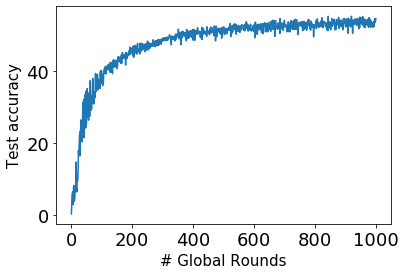

In [19]:
import matplotlib
step=1000
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
#plt.plot(range(len(Cluster0_minor1)), Cluster0_minor1,label="users=2,5,5,6,7")
plt.plot(range(len(acc_test_arr[0:step])), acc_test_arr[0:step],label="without sparsification")
plt.ylabel('Test accuracy')
plt.xlabel('# Global Rounds')
#plt.legend()
#plt.figure(figsize=(6,5), dpi=400)
plt.show()

In [ ]:
print(loss_train)

In [ ]:
print(max(acc_test_arr))

In [20]:
print(acc_test_arr[0:step])

[0.4316546618938446, 3.66906476020813, 5.731414794921875, 5.87529993057251, 6.570743560791016, 3.021582841873169, 3.573141574859619, 7.793765068054199, 8.321342468261719, 3.9088728427886963, 4.0767388343811035, 4.844124794006348, 7.2661871910095215, 6.570743560791016, 7.290167808532715, 14.820143699645996, 7.577937602996826, 7.386091232299805, 6.522781848907471, 11.390887260437012, 9.544364929199219, 11.055155754089355, 12.086331367492676, 17.985610961914062, 16.762590408325195, 18.96882438659668, 20.671463012695312, 22.517986297607422, 16.49880027770996, 23.30935287475586, 22.877696990966797, 26.49880027770996, 26.06714630126953, 24.556354522705078, 21.00719451904297, 20.40767478942871, 21.2230224609375, 29.832134246826172, 31.46282958984375, 25.251798629760742, 26.282974243164062, 32.15827178955078, 21.582733154296875, 25.779376983642578, 33.4532356262207, 25.515586853027344, 26.330934524536133, 24.292566299438477, 34.43645095825195, 25.251798629760742, 28.08153533935547, 27.24220657

In [ ]:
#torch.save(net_glob.state_dict(),"model_cnn.pt")
#for k in w_glob.keys():
#print(w_glob['conv1.weight'].to(torch.device("cuda"))-w_glob['conv1.weight'].to(torch.device("cuda")))

In [ ]:
print((w_glob))